In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

In [2]:
dir = "cell_images/cell_images"
listdir = os.listdir(dir)
listdir

['Uninfected', 'Parasitized']

In [3]:
Parasitized = os.listdir(dir + '/Parasitized')
Uninfected = os.listdir(dir + '/Uninfected')
print('count of Parasitized cell:{}, count of Uninfected cell:{}'.format(len(Parasitized), len(Uninfected)))

count of Parasitized cell:13780, count of Uninfected cell:13780


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Define your transforms for the training set
train_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                             transforms.ColorJitter(0.05),
                                             transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.RandomVerticalFlip(p=0.5),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set = datasets.ImageFolder(dir, transform = train_transforms)                                           

In [6]:
#create dataset
test_size = 0.1
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))


5511 2756 19291


In [7]:
from torch.utils.data.sampler import SubsetRandomSampler

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=50, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=20, 
    sampler=test_sampler)

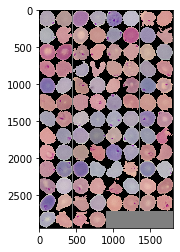

In [8]:
classes = ['Uninfected', 'Parasitized']
def matplotlib_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('')

images, labels = next(iter(train_loader))

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('image', img_grid, 0)
writer.close()

NOTE: the image color of tensorrboard is different from matplotlib which might be the colormap issue, still finding the solution

NOTE1: GoogleNet--try to used GoogleNet pretrained model but show below error
AttributeError: 'GoogLeNetOuputs' object has no attribute 'log_softmax'
SOLUTION:https://discuss.pytorch.org/t/question-about-googlenet/44896/2
If you don’t need the aux outputs, just pass the logits to your criterion as:

model = models.googlenet()

x = torch.randn(2, 3, 224, 224)
output = model(x)

criterion = nn.CrossEntropyLoss()
criterion(output.logits, torch.randint(0, 1000, (2,)))

However, show second error:
RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time
SOLUTION:https://zhuanlan.zhihu.com/p/68910558
loss.backward(retain_graph=True)
STILL GET ERROR :(

In [9]:
model = models.vgg16(pretrained=True, progress=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
!pip install torchsummary

In [10]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

from torchsummary import summary
summary(model.to(device), input_size=(3, 224, 224)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
writer.add_graph(model, images.to(device))
writer.close()

In [12]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Tracking model training with TensorBoard


In [13]:
# helper functions
import torch.nn.functional as F

def images_to_probs(model, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx])
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [14]:
valid_loss = 0.0
running_loss = 0.0
epochs=20
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    print('running epoch: {}'.format(epoch))
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    model.eval()
    for i, data in enumerate(valid_loader, 0):
        val_inputs, val_labels = data
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(val_inputs)
        # calculate the batch loss
        loss = criterion(output, val_labels)
        # update average validation loss 
        valid_loss += loss.item()
        
            # ...log the running loss
        writer.add_scalars('overall loss', {'training':running_loss / len(train_loader.dataset), 
                                           'validation':valid_loss / len(valid_loader.dataset)})

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
        writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels))
                            
        running_loss = 0.0
        writer.close()
print('Finished Training')

running epoch: 1
running epoch: 2
running epoch: 3
running epoch: 4
running epoch: 5
running epoch: 6
running epoch: 7
running epoch: 8
running epoch: 9
running epoch: 10
running epoch: 11
running epoch: 12
running epoch: 13
running epoch: 14
running epoch: 15
running epoch: 16
running epoch: 17
running epoch: 18
running epoch: 19
running epoch: 20
Finished Training


In [23]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
TensorBoard 2.1.0 at http://pytorch-vsc:6006/ (Press CTRL+C to quit)
W0404 12:07:28.885096 140262572787456 plugin_event_accumulator.py:294] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0404 12:07:28.885506 140262572787456 plugin_event_accumulator.py:322] Found more than one "run metadata" event with tag step1. Overwriting it with the newest event.
^C


In [19]:
##test data https://debuggercafe.com/track-your-pytorch-deep-learning-project-with-tensorboard/

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

In [22]:
for i in range(2):
    writer.add_histogram('test accuracy per class', 100 * class_correct[i] / class_total[i], i)
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
writer.close()

Accuracy of Uninfected : 96 %
Accuracy of Parasitized : 95 %
